# Build binary classifier to predict disease status from methylation biomarker 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GroupKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from scipy.stats import ttest_ind

# Data
- `mock.tsv` contains methylation data from 150 individuals as follows:
- A_xx, B_xx: methylation data from two orthogonal methods, e.g. A_0 is methylation measurement by method A at CpG site index 0. 
- Label: `1` (disease), `0` (no disease). There are 50 individuals with label 1 and 100 individuals with label 0.
- Cohort: There are 3 cohort groups (`Aug`, `Jul`, `Mar`), each with 50 individuals
- Cohort: Data from same cohort are from the same batch of experiment. All the data are from the identical biological population. Any differences between different Cohorts is not due to internal factor (e.g. health condition) but due to external factors (e.g. different experimental conditions or seasonal effect).   

In [3]:
# 1) Load your data
df = pd.read_csv('../data/mock.tsv', sep='\t')   # or wherever your file lives
df

,Cohort,Label,A_0,A_1,A_2,A_3,A_4,A_5,A_6,A_7,...,B_90,B_91,B_92,B_93,B_94,B_95,B_96,B_97,B_98,B_99
0,Aug,0,1.621774,1.739324,1.451617,-0.186583,2.376608,2.295373,2.722720,1.821542,...,0.864761,0.134935,0.242494,0.359284,0.003831,0.069875,0.259369,0.244837,0.554309,0.733232
1,Aug,0,2.767240,1.079509,-0.723664,1.737466,1.844370,2.059156,2.358058,1.868140,...,0.030889,0.226631,0.329706,0.826815,0.317215,0.114622,0.588142,0.668808,0.491239,0.572640
2,Aug,0,2.122517,0.713271,2.915116,1.313582,2.152386,0.885216,2.853469,0.424814,...,0.830995,0.242558,0.841052,0.958406,0.721642,0.753970,0.840054,0.979133,0.357064,0.194532
3,Aug,0,1.802962,3.129745,2.488166,0.917015,2.729987,1.810858,2.108782,0.664469,...,0.391327,0.153289,0.214403,0.113282,0.563799,0.164133,0.262977,0.387080,0.846162,0.564837
4,Aug,0,0.367035,2.749154,1.558293,1.304794,0.857214,3.152263,1.684176,1.667096,...,0.029424,0.986045,0.232829,0.953272,0.918123,0.857471,0.303726,0.404233,0.050626,0.203764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,Mar,1,-1.682147,-1.262470,-3.842003,-2.204974,-0.902512,0.520465,-1.227517,-0.628699,...,0.509399,0.705261,0.230260,0.958283,0.673974,0.601420,0.256721,0.232084,0.994775,0.611156
146,Mar,1,-1.386700,-1.253194,-1.945290,-3.505696,-1.847696,-0.841383,-1.970503,-2.129677,...,0.146937,0.603260,0.806180,0.410741,0.930247,0.837703,0.330396,0.603705,0.338051,0.464377
147,Mar,1,0.296081,-1.919121,0.350761,-1.491252,-1.950832,-2.100143,-1.230885,-0.888188,...,0.991078,0.623959,0.127712,0.553945,0.162934,0.777856,0.835434,0.857982,0.725078,0.798173
148,Mar,1,-1.528270,-2.667680,-1.118364,-2.586643,-1.151861,-1.574978,-3.201278,-2.337745,...,0.080779,0.995426,0.707016,0.680826,0.738497,0.551783,0.526466,0.421607,0.851696,0.403886


In [10]:
df.describe()

,Label,A_0,A_1,A_2,A_3,A_4,A_5,A_6,A_7,A_8,...,B_90,B_91,B_92,B_93,B_94,B_95,B_96,B_97,B_98,B_99
count,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,...,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000
mean,0.333333,0.015220,0.140165,0.021821,-0.030985,0.068323,0.037672,0.009450,0.065126,0.062814,...,0.513884,0.506445,0.469890,0.539114,0.519623,0.516196,0.477588,0.478443,0.504669,0.508435
std,0.472984,1.464204,1.572276,1.594300,1.574234,1.599172,1.576521,1.588574,1.471894,1.475776,...,0.295635,0.280242,0.278824,0.304114,0.294974,0.289017,0.294289,0.291993,0.301260,0.284987
min,0.000000,-3.420240,-4.041328,-4.124623,-4.132140,-3.332007,-3.490635,-4.069157,-3.223239,-4.292058,...,0.024421,0.008030,0.001550,0.001515,0.003831,0.003074,0.008614,0.000122,0.005974,0.012785
25%,0.000000,-1.110903,-1.108050,-1.200538,-1.072789,-1.161243,-1.138308,-1.147728,-0.929168,-1.011457,...,0.247721,0.262947,0.230617,0.272162,0.215464,0.255202,0.227311,0.209908,0.230311,0.245110
50%,0.000000,0.147722,0.157458,0.145486,-0.075126,0.313973,0.049026,0.038208,-0.144688,0.023032,...,0.528238,0.505223,0.446633,0.549464,0.571182,0.528890,0.470972,0.485379,0.493107,0.555164
75%,1.000000,1.131175,1.336413,1.206092,1.100301,1.168958,1.097209,1.167444,1.161484,1.002566,...,0.780865,0.708282,0.734517,0.799381,0.763507,0.753091,0.700890,0.735972,0.779448,0.749168
max,1.000000,3.972569,4.191416,3.771835,3.142500,3.672911,3.668122,3.496951,4.411386,4.697143,...,0.991078,0.995426,0.993179,0.995125,0.999196,0.994905,0.996274,0.994491,0.995594,0.990170


In [4]:
df.Cohort.unique()

array(['Aug', 'Jul', 'Mar'], dtype=object)

In [30]:
for cohort in df['Cohort'].unique():
    count = (df['Cohort'] == cohort).sum()
    print(f"Num of samples with Cohort == {cohort}: {count}")

print(f"Num of sample with Label == 0 is {sum(df.Label==0)}")
print(f"Num of sample with Label == 1 is {sum(df.Label==1)}")    


Num of samples with Cohort == Aug: 50
Num of samples with Cohort == Jul: 50
Num of samples with Cohort == Mar: 50
Num of sample with Label == 0 is 100
Num of sample with Label == 1 is 50


# Compare singal level between label 1 vs label 0 for each feature
* A47 looks significantly different between the two groups (label0 vs label1)

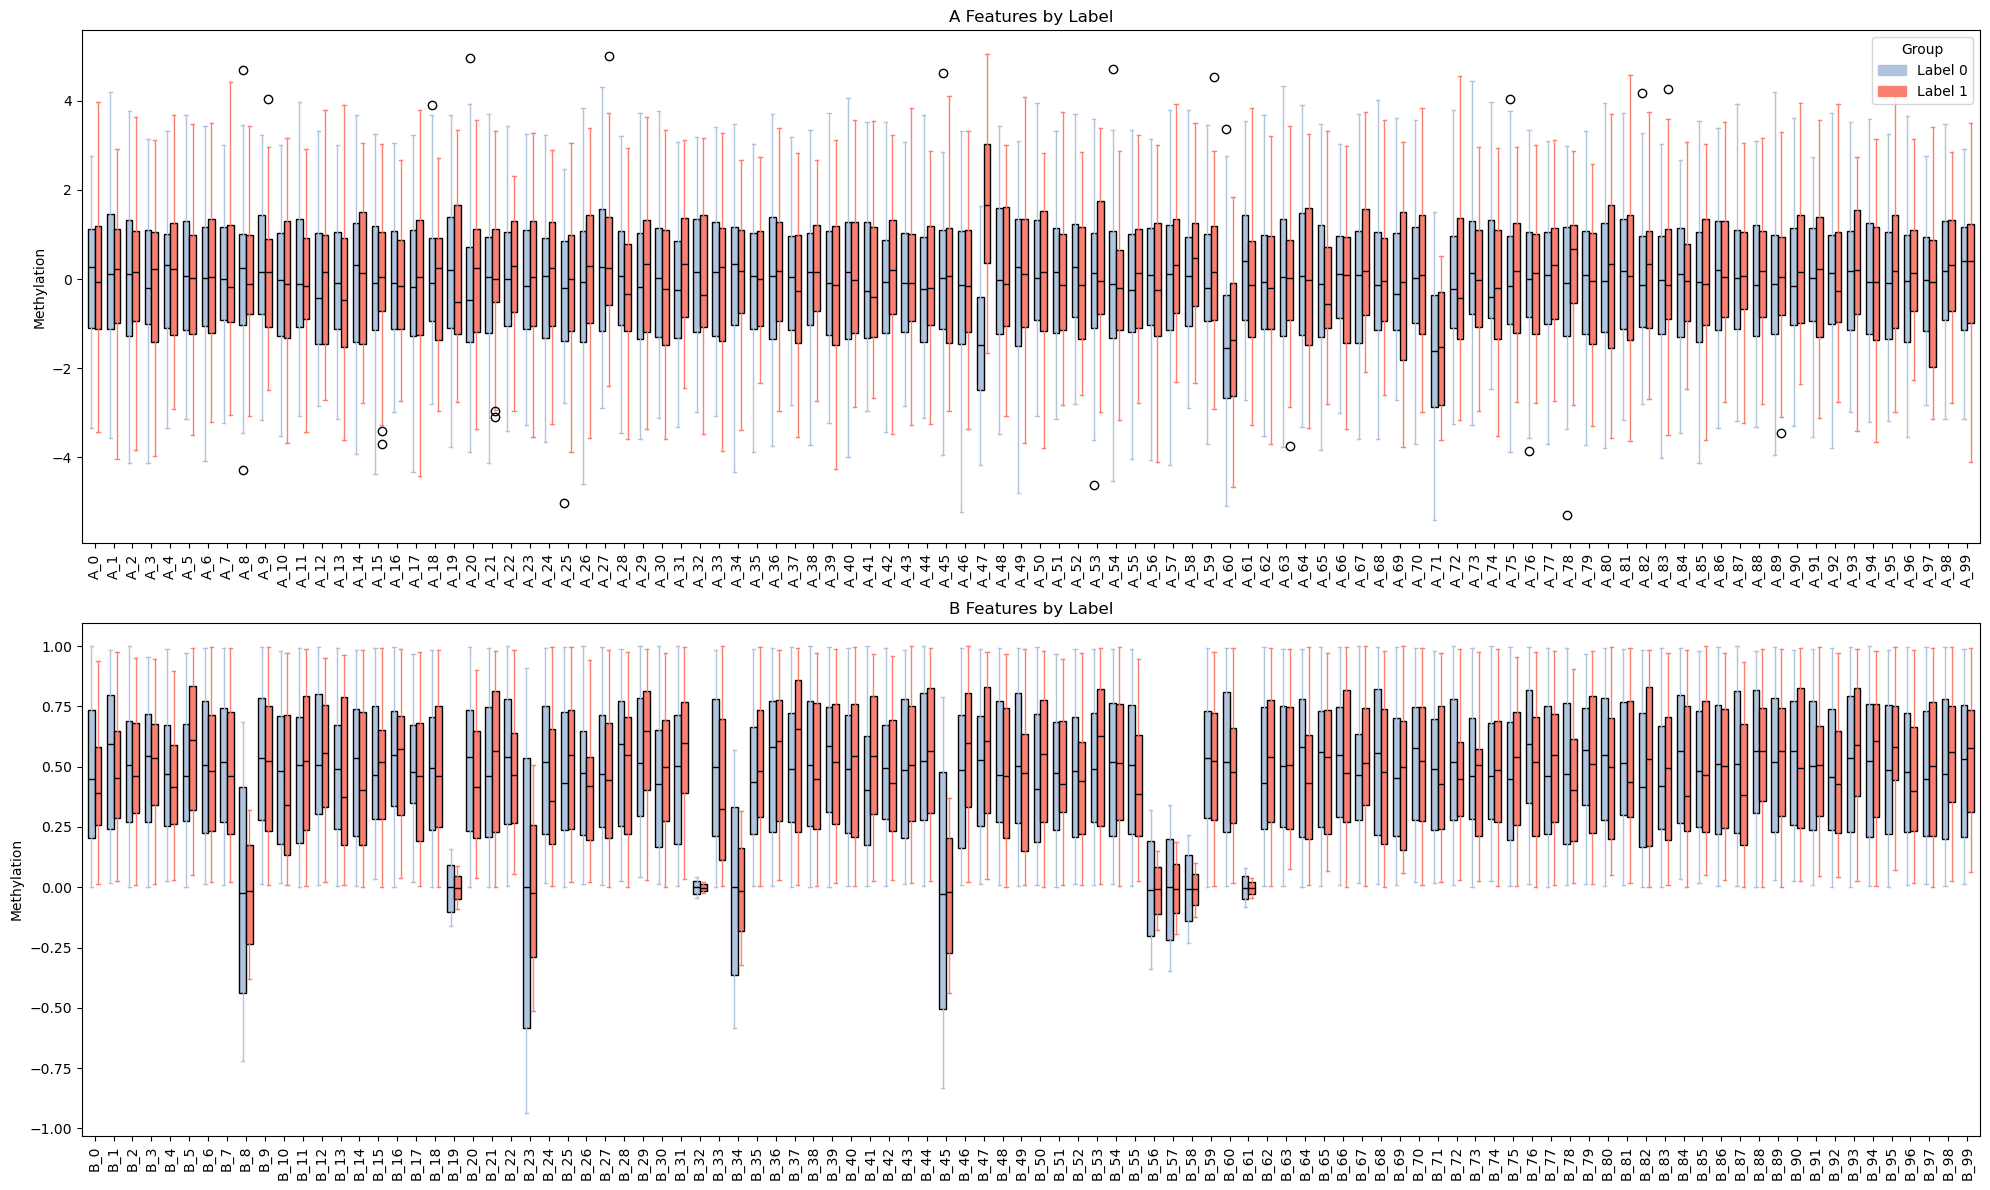

In [19]:
# 1) Identify features & labels
features_A = [c for c in df.columns if c.startswith('A_')]
features_B = [c for c in df.columns if c.startswith('B_')]
labels     = sorted(df['Label'].unique())

# 2) Plot setup
width = 0.35
colors = {0: "lightsteelblue", 1: "salmon"}

fig, axes = plt.subplots(2, 1, figsize=(20, 12), sharex=False)

for ax, features, title in zip(axes,
                               [features_A, features_B],
                               ['A Features', 'B Features']):
    x = np.arange(len(features))
    for idx, label in enumerate(labels):
        data = [df[df['Label'] == label][feat] for feat in features]
        positions = x + (idx - 0.5) * width
        bp = ax.boxplot(data, positions=positions, widths=width, patch_artist=True)
        for box in bp['boxes']:
            box.set_facecolor(colors[label])
        for component in ('whiskers','caps','medians'):
            for art in bp[component]:
                art.set_color(colors[label] if component!='medians' else 'black')
    ax.set_title(f'{title} by Label')
    ax.set_xticks(x)
    ax.set_xticklabels(features, rotation=90)
    ax.set_ylabel('Methylation')

# build one shared legend on the first subplot
patches = [mpatches.Patch(color=colors[l], label=f'Label {l}') for l in labels]
axes[0].legend(handles=patches, loc='upper right', title='Group')

plt.tight_layout()
plt.show()

# t-test to yield p-value between the two groups (label 0 vs label 1) per feature 
* A47 is the unique feature that is significantly different from group label 0 and label 1 with p-value ~ 10^(-17)

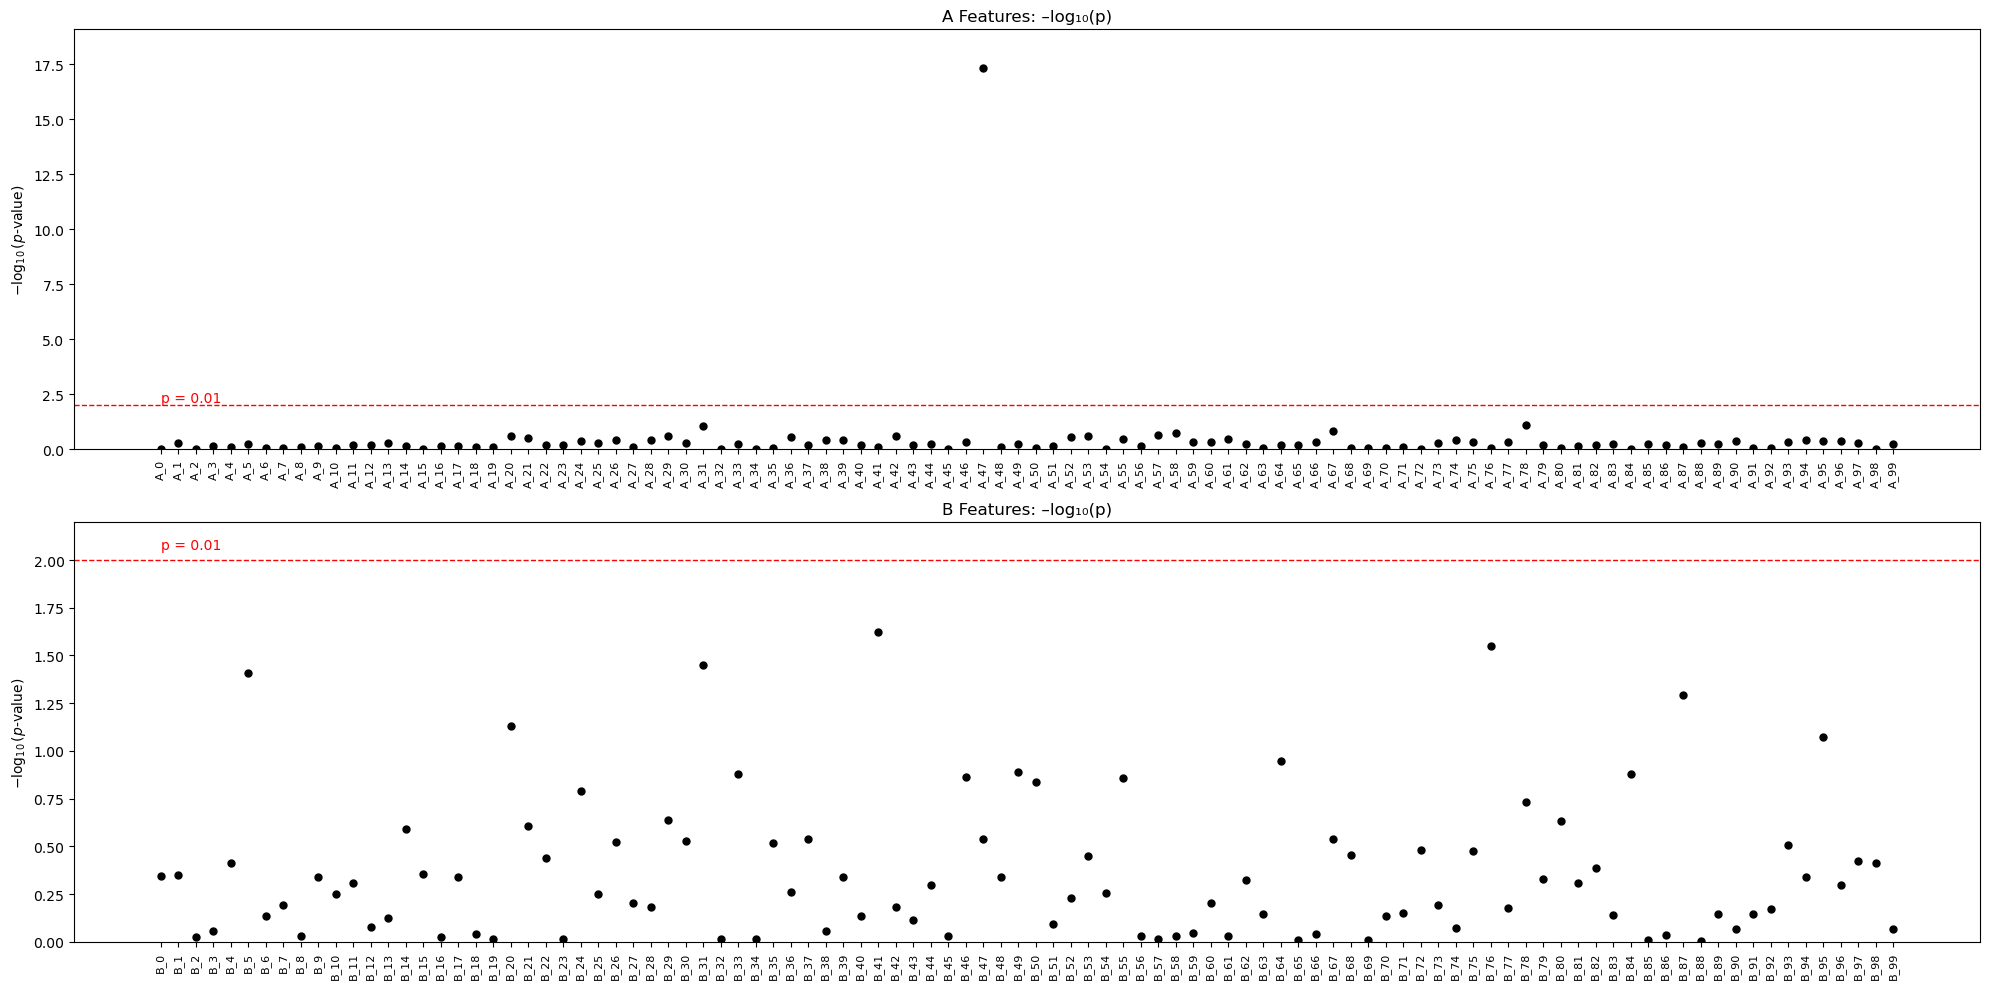

In [ ]:
# 2) Prepare subplots
fig, axs = plt.subplots(2, 1, figsize=(20, 10), sharex=False)

for ax, features, title in zip(
    axs,
    [features_A, features_B],
    ['A Features: –log₁₀(p)', 'B Features: –log₁₀(p)']
):
    # compute p-values
    pvals = []
    for feat in features:
        g0 = df.loc[df['Label'] == labels[0], feat].dropna()
        g1 = df.loc[df['Label'] == labels[1], feat].dropna()
        _, p = ttest_ind(g0, g1, equal_var=False)
        pvals.append(p)
    minus_log_p = -np.log10(pvals)

    # scatter plot
    x = np.arange(len(features))
    ax.scatter(x, minus_log_p, color='black', s=25, zorder=5)

    # formatting
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(features, rotation=90, fontsize=8)
    ax.set_ylabel(r'$-\log_{10}(p\text{-value})$')

    # optional: mark significance threshold at p=0.01
    sig_line = -np.log10(0.01)
    ax.set_ylim(0, max(np.max(minus_log_p), sig_line) * 1.1)  # add a little headroom
    ax.axhline(sig_line, color='red', linestyle='--', linewidth=1)
    ax.text(0, sig_line * 1.02, 'p = 0.01', color='red', va='bottom')

plt.tight_layout()
plt.show()


# A47 is a feature to differentiate label 0 vs label 1

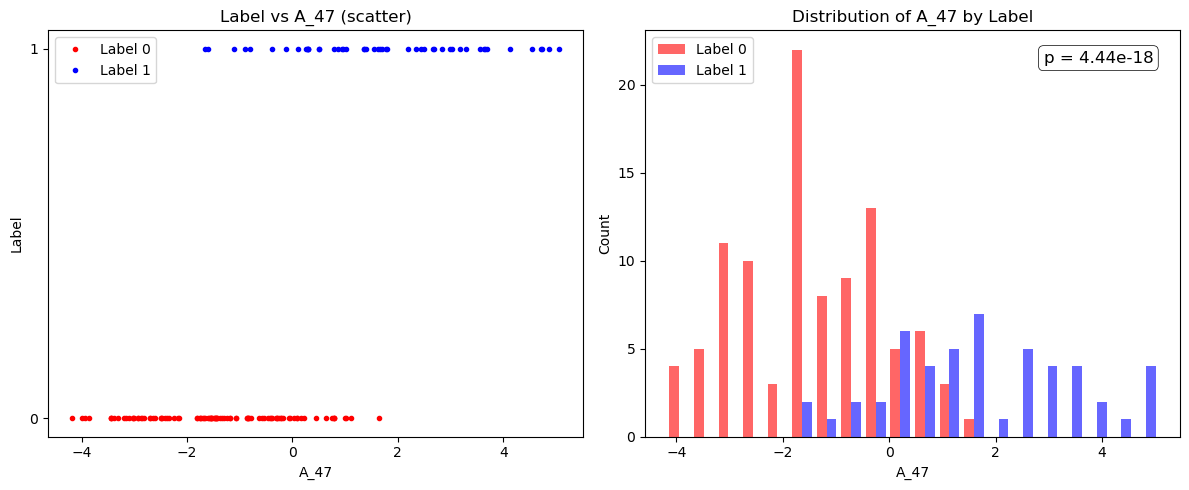

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# 1) Data subsets
x0 = df.loc[df.Label == 0, 'A_47'].dropna()
x1 = df.loc[df.Label == 1, 'A_47'].dropna()

# 2) Compute p-value (Welch’s t-test)
stat, pval = ttest_ind(x0, x1, equal_var=False)import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# 1) Data subsets
x0 = df.loc[df.Label == 0, 'A_47'].dropna()
x1 = df.loc[df.Label == 1, 'A_47'].dropna()

# 2) Compute p-value (Welch’s t-test)
_, pval = ttest_ind(x0, x1, equal_var=False)

# 3) Create subplots
fig, (ax_scatter, ax_hist) = plt.subplots(1, 2, figsize=(12, 5))

# — Scatter plot —
ax_scatter.plot(x0, np.zeros_like(x0), 'r.', label='Label 0')
ax_scatter.plot(x1, np.ones_like(x1), 'b.', label='Label 1')
ax_scatter.set_xlabel('A_47')
ax_scatter.set_ylabel('Label')
ax_scatter.set_yticks([0, 1])
ax_scatter.set_yticklabels(['0', '1'])
ax_scatter.set_title('Label vs A_47 (scatter)')
ax_scatter.legend()

# — Overlapping histogram —
ax_hist.hist(x0, bins=20, alpha=0.6, color='red',   label='Label 0')
ax_hist.hist(x1, bins=20, alpha=0.6, color='blue',  label='Label 1')
ax_hist.set_xlabel('A_47')
ax_hist.set_ylabel('Count')
ax_hist.set_title('Distribution of A_47 by Label')
ax_hist.legend()

# annotate p-value in axis-relative coords
ax_hist.text(
    0.95, 0.95,
    f"p = {pval:.2e}",
    transform=ax_hist.transAxes,
    ha='right', va='top',
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0.5)
)

plt.tight_layout()
plt.show()


# 3) Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left: scatter plot
ax = axes[0]
ax.plot(x0, np.zeros_like(x0), 'r.', label='Label 0')
ax.plot(x1, np.ones_like(x1), 'b.', label='Label 1')
ax.set_xlabel('A_47')
ax.set_ylabel('Label')
ax.set_yticks([0,1])
ax.set_yticklabels(['0','1'])
ax.set_title('Label vs A_47 (scatter)')
ax.legend()

# Right: histogram + p-value annotation
ax = axes[1]
ax.hist([x0, x1], bins=20, color=['red','blue'], alpha=0.6, label=['Label 0', 'Label 1'])
ax.set_xlabel('A_47')
ax.set_ylabel('Count')
ax.set_title('Distribution of A_47 by Label')
ax.legend()

# annotate p-value in axis‐relative coords
ax.text(0.95, 0.95,
        f"p = {pval:.2e}",
        transform=ax.transAxes,
        ha='right',
        va='top',
        fontsize=12,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0.5))

plt.tight_layout()
plt.show()


# There is a batch effect by cohort which can be eliminated by rescale

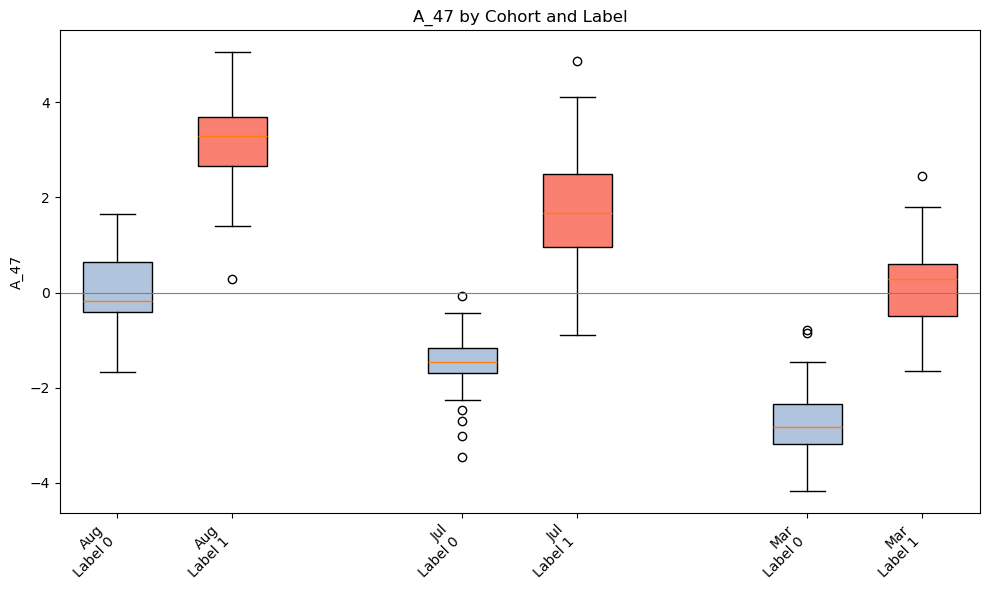

In [36]:
# 1) Parameters
feature = 'A_47'  # change to any A_xx or B_xx
cohorts = df['Cohort'].unique()  # pick your three cohort names
labels  = [0, 1]
width   = 0.6

# 2) Gather data & positions
data = []
positions = []
xticks = []
for i, cohort in enumerate(cohorts):
    for j, lab in enumerate(labels):
        subset = df[(df['Cohort'] == cohort) & (df['Label'] == lab)][feature]
        data.append(subset)
        # position pairs at (i*3 + j)
        positions.append(i * (len(labels) + 1) + j)
        xticks.append(f"{cohort}\nLabel {lab}")

# 3) Plot
fig, ax = plt.subplots(figsize=(10, 6))
bp = ax.boxplot(data, positions=positions, widths=width, patch_artist=True)

# 4) Color alternating by label
colors = ['lightsteelblue', 'salmon'] * len(cohorts)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# 5) Ticks & labels
ax.set_xticks(positions)
ax.set_xticklabels(xticks, rotation=45, ha='right')
ax.set_ylabel(feature)
ax.set_title(f"{feature} by Cohort and Label")
ax.axhline(0, color='gray', linewidth=0.8)

plt.tight_layout()
plt.show()

# Cohort‐wise Z-score (subtract mean, divide by std)
* The trend between Label 0 vs Label 1 is consistent, but there is batch effect among different Cohort. 
* Data need to be rescaled (subtract by mean, and normalizaed by the std) to stay in the similar scale range. 
* Rescale needs to be done per each cohort to take into account the batch effect. 

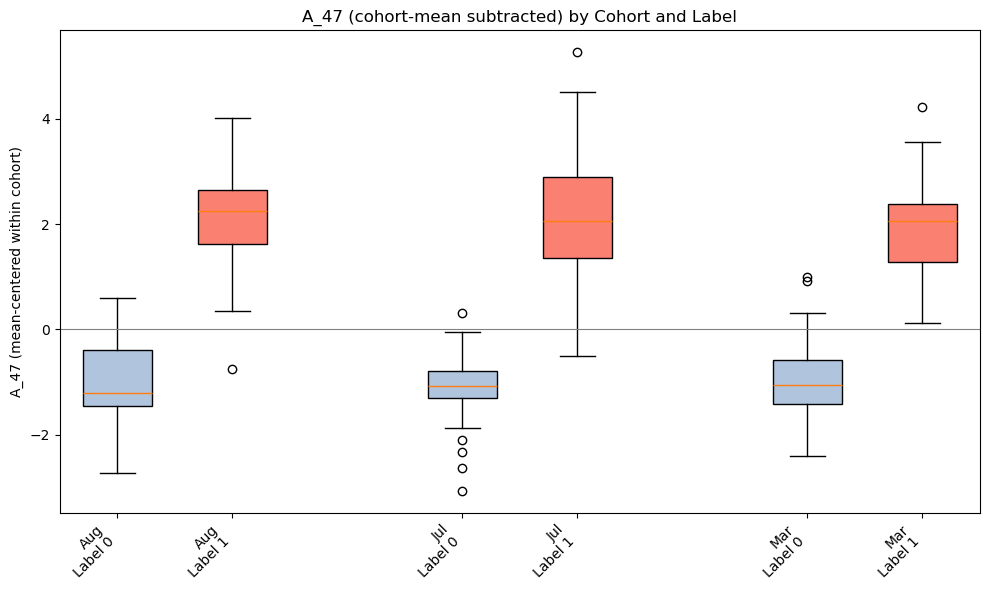

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Parameters
feature  = 'A_47'  
cohorts  = df['Cohort'].unique()  
labels   = [0, 1]
width    = 0.6

# 2) Create an adjusted column
adj_col = feature + '_adj'
df[adj_col] = df.groupby('Cohort')[feature]\
                .transform(lambda x: x - x.mean())

# 3) Gather data & positions (but now using the adjusted values)
data      = []
positions = []
xticks    = []
for i, cohort in enumerate(cohorts):
    for j, lab in enumerate(labels):
        subset = df[(df['Cohort'] == cohort) & (df['Label'] == lab)][adj_col]
        data.append(subset)
        pos = i * (len(labels) + 1) + j
        positions.append(pos)
        xticks.append(f"{cohort}\nLabel {lab}")

# 4) Plot
fig, ax = plt.subplots(figsize=(10, 6))
bp = ax.boxplot(data,
                positions=positions,
                widths=width,
                patch_artist=True)

# 5) Color by label
colors = ['lightsteelblue', 'salmon'] * len(cohorts)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# 6) Ticks & labels
ax.set_xticks(positions)
ax.set_xticklabels(xticks, rotation=45, ha='right')

ax.set_ylabel(f"{feature} (mean-centered within cohort)")
ax.set_title(f"{feature} (cohort-mean subtracted) by Cohort and Label")
ax.axhline(0, color='gray', linewidth=0.8)  # zero‐line is now cohort mean

plt.tight_layout()
plt.show()


In [23]:
# 2) Copy the DataFrame
df_z = df.copy()

# 3) Cohort‐wise Z-scoring, done separately for A and B features
df_z[features_A] = (
    df_z
      .groupby('Cohort')[features_A]
      .transform(lambda col: (col - col.mean()) / col.std())
)

df_z[features_B] = (
    df_z
      .groupby('Cohort')[features_B]
      .transform(lambda col: (col - col.mean()) / col.std())
)

# Now df_z.A_xx and df_z.B_xx are each z-scored within their cohort

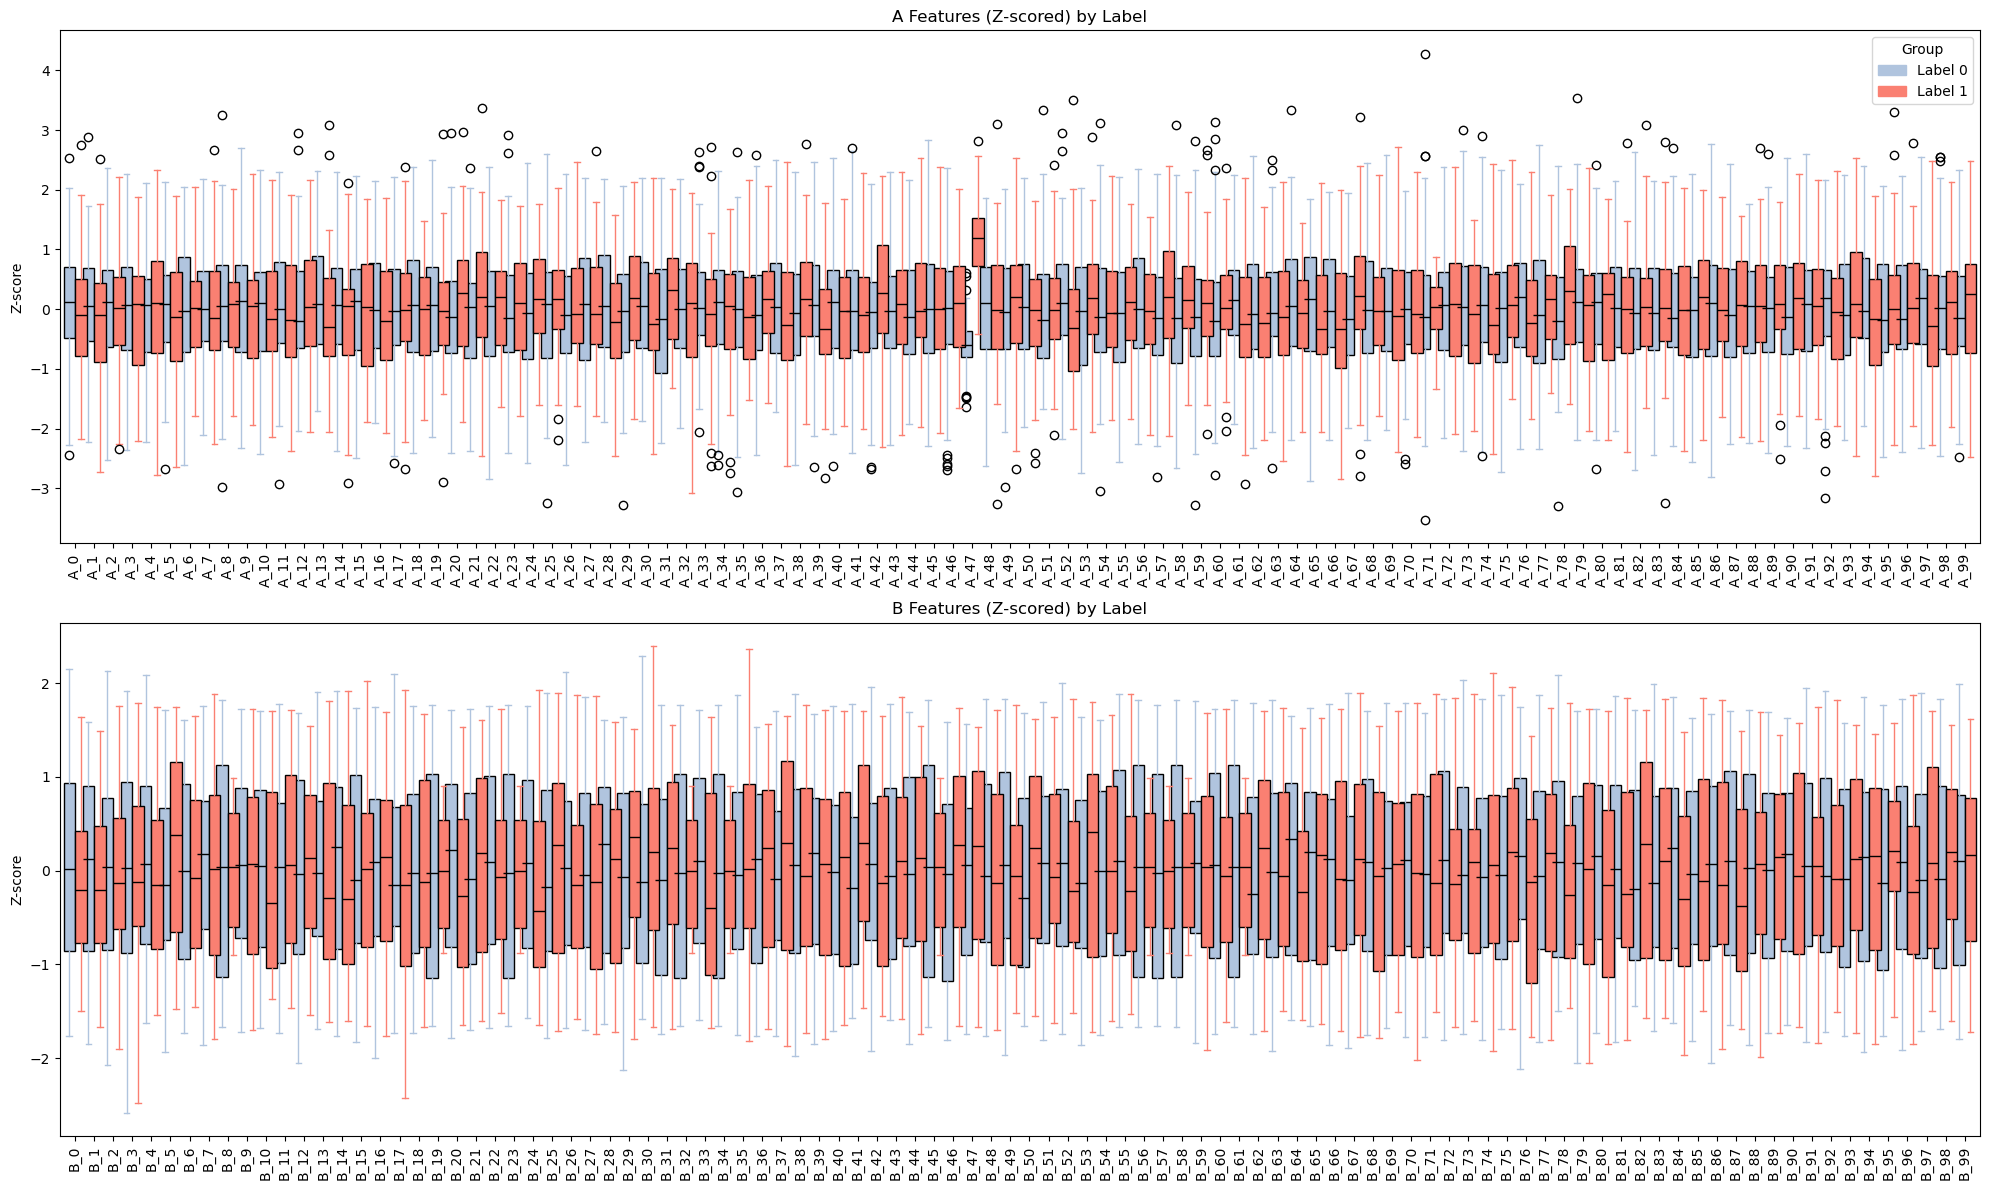

In [24]:
# Plot normalized (df_z) A and B features by label
fig, axes = plt.subplots(2, 1, figsize=(20, 12), sharex=False)

for ax, features, title in zip(
        axes,
        [features_A, features_B],
        ['A Features (Z-scored)', 'B Features (Z-scored)']
    ):
    x = np.arange(len(features))
    for idx, label in enumerate(labels):
        # use df_z instead of df
        data = [df_z[df_z['Label'] == label][feat] for feat in features]
        positions = x + (idx - 0.5) * width
        bp = ax.boxplot(data, positions=positions, widths=width, patch_artist=True)
        for box in bp['boxes']:
            box.set_facecolor(colors[label])
        for component in ('whiskers', 'caps', 'medians'):
            for art in bp[component]:
                art.set_color(colors[label] if component != 'medians' else 'black')
    ax.set_title(f'{title} by Label')
    ax.set_xticks(x)
    ax.set_xticklabels(features, rotation=90)
    ax.set_ylabel('Z-score')

# shared legend
patches = [mpatches.Patch(color=colors[l], label=f'Label {l}') for l in labels]
axes[0].legend(handles=patches, loc='upper right', title='Group')

plt.tight_layout()
plt.show()

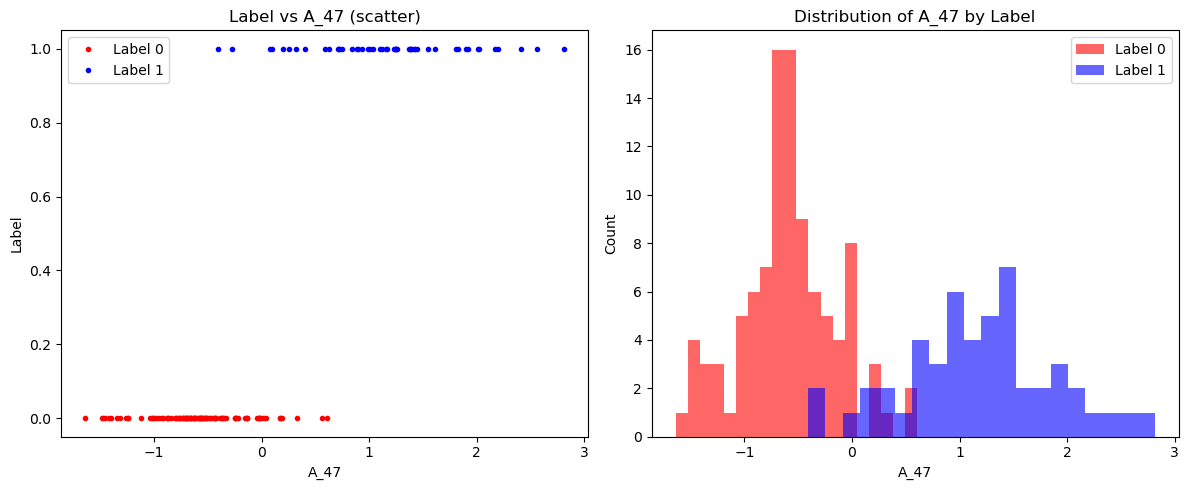

In [25]:
# Data subsets
x0 = df_z.A_47[df.Label == 0]
x1 = df_z.A_47[df.Label == 1]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left: scatter plot
ax = axes[0]
ax.plot(x0, [0]*len(x0), 'r.', label='Label 0')
ax.plot(x1, [1]*len(x1), 'b.', label='Label 1')
ax.set_xlabel('A_47')
ax.set_ylabel('Label')
ax.set_title('Label vs A_47 (scatter)')
ax.legend()

# Right: histogram
ax = axes[1]
ax.hist(x0, bins=20, alpha=0.6, color='red', label='Label 0')
ax.hist(x1, bins=20, alpha=0.6, color='blue', label='Label 1')
ax.set_xlabel('A_47')
ax.set_ylabel('Count')
ax.set_title('Distribution of A_47 by Label')
ax.legend()

plt.tight_layout()
plt.show()

# Observation so far:
- A47 is the only methylation site that shows significantly diferent signal betwen label 0 and label 1. 
- Now I will build a binary classifier 

In [107]:
# 2) Define feature sets
A_feats    = [c for c in df.columns if c.startswith('A_')]
B_feats    = [c for c in df.columns if c.startswith('B_')]
AB_feats   = A_feats + B_feats
cat_feats  = ['Cohort']       # now included as a model input

In [108]:
# 3) Build X/y (include cohort in X)
X      = df[AB_feats]
y      = df['Label']          # target: 0 or 1
groups = df['Cohort']         # you can still use this for GroupKFold if desired

In [109]:
# 4) Split off a held-out test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [110]:
# 5) Preprocessing pipelines
numeric_pipe = Pipeline([
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipe, AB_feats),
])

In [111]:
# 6) Candidate models (with preprocessing built in)
models = {
    'LogisticRegression': Pipeline([
        ('prep', preprocessor),
        ('clf', LogisticRegression(
            solver='saga',
            penalty='l2',
            C=1.0,
            max_iter=2000,
            n_jobs=-1,
            random_state=42
        ))
    ]),
}

In [112]:
# --- 1) Re-fit simple models on just A/B features (no cohort) ---
X_AB = df[AB_feats]      # AB_feats = all your A_/B_ columns
y = df['Label']

# Logistic Regression (with scaling)
scaler = StandardScaler().fit(X_AB)
X_scaled = scaler.transform(X_AB)
lr = LogisticRegression(solver='saga', penalty='l2', C=1.0, max_iter=2000, random_state=42)
lr.fit(X_scaled, y)

# --- 2) Extract importances / coefficients ---
lr_coef = pd.Series(lr.coef_.flatten(), index=AB_feats).abs()

# --- 3) Find top feature in each group ---
top_A_lr = lr_coef.filter(like='A_').nlargest(1)
top_B_lr = lr_coef.filter(like='B_').nlargest(1)

print("\n=== Logistic Regression (abs coef) ===")
print("Top A-feature:", top_A_lr.index[0], "coef=", top_A_lr.iloc[0])
print("Top B-feature:", top_B_lr.index[0], "coef=", top_B_lr.iloc[0])


=== Logistic Regression (abs coef) ===
Top A-feature: A_47 coef= 2.4013021779273953
Top B-feature: B_5 coef= 0.6029317758099714


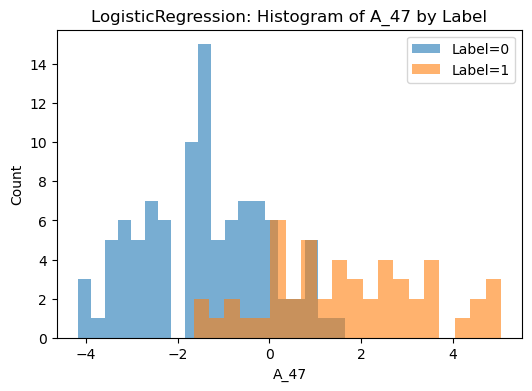

/var/folders/h0/hyrmq_xj0nz_7j032crdtlrh0000gn/T/ipykernel_97570/301399541.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([data0, data1], labels=['0','1'])


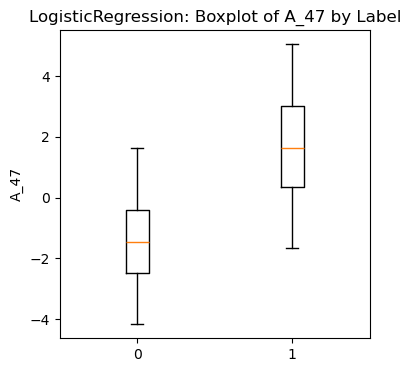

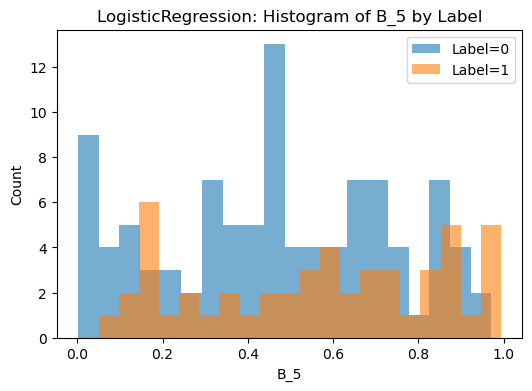

/var/folders/h0/hyrmq_xj0nz_7j032crdtlrh0000gn/T/ipykernel_97570/301399541.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([data0, data1], labels=['0','1'])


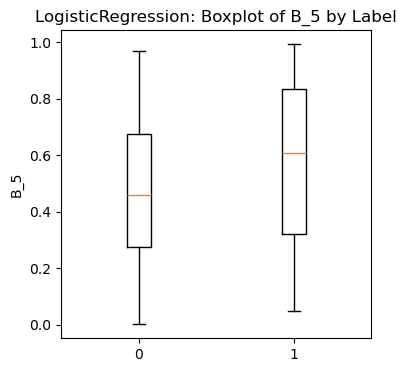

In [114]:
import matplotlib.pyplot as plt

top_feats = {
    'LogisticRegression': {'A': 'A_47', 'B': 'B_5'}
}

for model, feats in top_feats.items():
    for group, feat in feats.items():
        # 1) Overlaid histograms
        plt.figure(figsize=(6,4))
        plt.hist(df.loc[df.Label==0, feat], bins=20, alpha=0.6, label='Label=0')
        plt.hist(df.loc[df.Label==1, feat], bins=20, alpha=0.6, label='Label=1')
        plt.title(f'{model}: Histogram of {feat} by Label')
        plt.xlabel(feat)
        plt.ylabel('Count')
        plt.legend()
        plt.show()

        # 2) Side-by-side boxplot
        data0 = df.loc[df.Label==0, feat]
        data1 = df.loc[df.Label==1, feat]
        fig, ax = plt.subplots(figsize=(4,4))
        ax.boxplot([data0, data1], labels=['0','1'])
        ax.set_title(f'{model}: Boxplot of {feat} by Label')
        ax.set_ylabel(feat)
        plt.show()

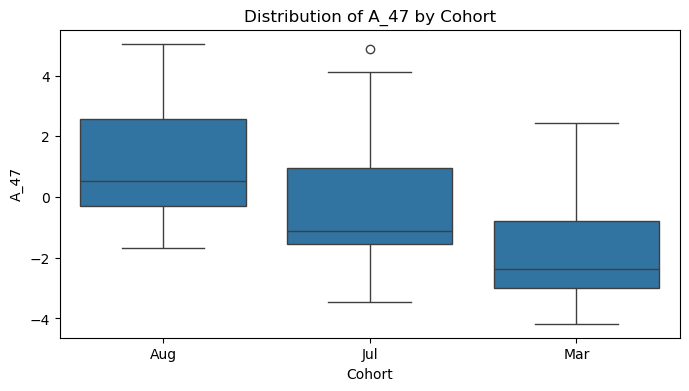

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,4))
sns.boxplot(x='Cohort', y='A_47', data=df, order=sorted(df['Cohort'].unique()))
plt.title('Distribution of A_47 by Cohort')
plt.show()


In [75]:
import pandas as pd

# 1) Suppose df already has your AB_feats list and ‘Cohort’
AB_feats = [c for c in df.columns if c.startswith('A_') or c.startswith('B_')]

# 2) Apply group‐wise scaling: (x - mean_of_cohort) / std_of_cohort
df_scaled = df.copy()
df_scaled[AB_feats] = (
    df_scaled
      .groupby('Cohort')[AB_feats]
      .transform(lambda x: (x - x.mean()) / x.std(ddof=0))
)

# 3) Now df_scaled[AB_feats] contains cohort-normalized values.
#    You can drop ‘Cohort’ (or still encode it) and train on df_scaled:

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler  # optional: further global scaling
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report

X = df_scaled[AB_feats]     # cohort effects removed
y = df_scaled['Label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

pipe = Pipeline([
    # Optional: a second, global scaler if you like:
    ('global_scale', StandardScaler()),
    ('clf', LogisticRegression(solver='saga', max_iter=2000, random_state=42))
])
pipe.fit(X_train, y_train)

y_pred  = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:,1]

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Test AUC-ROC:", roc_auc_score(y_test, y_proba))


Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.85      0.83        20
           1       0.67      0.60      0.63        10

    accuracy                           0.77        30
   macro avg       0.74      0.72      0.73        30
weighted avg       0.76      0.77      0.76        30

Test AUC-ROC: 0.8800000000000001


In [76]:
import pandas as pd
from sklearn.metrics import roc_auc_score

# 1) Work on your cohort-scaled DataFrame:
#    df_scaled[AB_feats] already has (x - μ_cohort)/σ_cohort
X = df_scaled[AB_feats]
y = df_scaled['Label']

# 2) Compute AUC for each feature individually
feature_aucs = {}
for feat in AB_feats:
    # roc_auc_score will treat feat as a “score” for Label=1
    feature_aucs[feat] = roc_auc_score(y, X[feat])

# 3) Split into A_ and B_ lists and pick the top
A_auc = {f: feature_aucs[f] for f in A_feats}
B_auc = {f: feature_aucs[f] for f in B_feats}

top_A = max(A_auc, key=A_auc.get)
top_B = max(B_auc, key=B_auc.get)

print(f"Top A feature: {top_A} → AUC = {A_auc[top_A]:.3f}")
print(f"Top B feature: {top_B} → AUC = {B_auc[top_B]:.3f}")


Top A feature: A_47 → AUC = 0.985
Top B feature: B_41 → AUC = 0.614


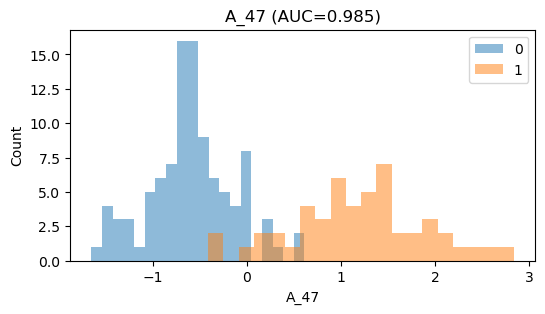

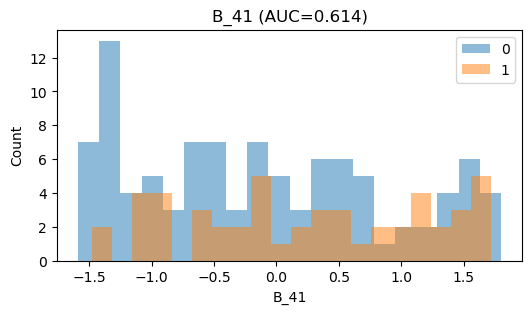

In [77]:
import matplotlib.pyplot as plt

for feat, auc in [('A_47', 0.985), ('B_41', 0.614)]:
    plt.figure(figsize=(6,3))
    plt.hist(df_scaled.loc[df_scaled.Label==0, feat], bins=20, alpha=0.5, label='0')
    plt.hist(df_scaled.loc[df_scaled.Label==1, feat], bins=20, alpha=0.5, label='1')
    plt.title(f'{feat} (AUC={auc:.3f})')
    plt.xlabel(feat); plt.ylabel('Count'); plt.legend()
    plt.show()


In [80]:
# Assume df_scaled already has (x - mean_cohort)/std_cohort for A_47
X = df_scaled[['A_47']]
y = df_scaled['Label']

# 1) Hold out a test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# 2) Fit Logistic Regression
clf = LogisticRegression(
    solver='liblinear',   # fine for 1D
    random_state=42
).fit(X_train, y_train)

# 3) Predict & Evaluate
y_pred  = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:,1]

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Test AUC-ROC:", roc_auc_score(y_test, y_proba))

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95        20
           1       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30

Test AUC-ROC: 0.98


In [81]:
# Assume df_scaled already has (x - mean_cohort)/std_cohort for A_47
X = df_scaled[['A_47']]
y = df_scaled['Label']

# 1) Hold out a test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# 2) Fit Logistic Regression
clf = LogisticRegression(
    solver='liblinear',   # fine for 1D
    random_state=42
).fit(X_train, y_train)

# 3) Predict & Evaluate
y_pred  = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:,1]

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Test AUC-ROC:", roc_auc_score(y_test, y_proba))

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95        20
           1       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30

Test AUC-ROC: 0.98


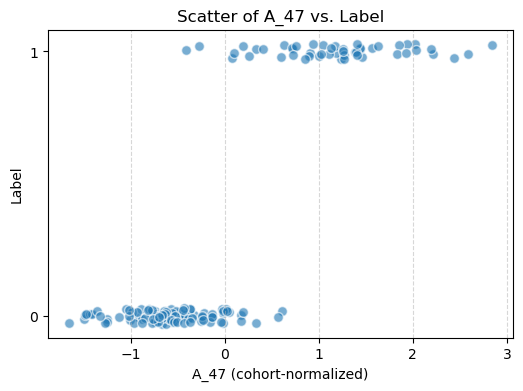

In [82]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Extract x and y
x = df_scaled['A_47']
y = df_scaled['Label']

# 2) Add a bit of jitter on y so 0’s and 1’s don’t fully overlap
y_jitter = y + np.random.uniform(-0.03, 0.03, size=len(y))

# 3) Scatter plot
plt.figure(figsize=(6,4))
plt.scatter(x, y_jitter, alpha=0.6, edgecolor='w', s=50)
plt.yticks([0,1])
plt.xlabel('A_47 (cohort-normalized)')
plt.ylabel('Label')
plt.title('Scatter of A_47 vs. Label')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()
